# Chess Game Outcome Prediction

This notebook implements a neural network to predict chess game outcomes (White win, Black win, or Draw) after analyzing the first n moves of each game.

## Step 1: Environment Setup and Dependencies


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import chess
import chess.svg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython.display import HTML, display, SVG
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Print library versions to verify installation
print("Library versions:")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"tensorflow: {tf.__version__}")
print(f"python-chess: {chess.__version__}")
print(f"matplotlib: {plt.matplotlib.__version__}")

# Configuration parameters
N_MOVES = 10  # Number of half-moves (plies) to analyze
print(f"\nConfiguration: Analyzing first {N_MOVES} moves of each game")

# Test basic functionality
print("\nTesting basic functionality:")
print("✓ All libraries imported successfully")
print("✓ TensorFlow backend ready")
print("✓ Chess library ready for board manipulation")
print("✓ Matplotlib ready for visualization")


Library versions:
pandas: 2.3.3
numpy: 2.3.4
tensorflow: 2.20.0
python-chess: 1.11.2
matplotlib: 3.10.7

Configuration: Analyzing first 10 moves of each game

Testing basic functionality:
✓ All libraries imported successfully
✓ TensorFlow backend ready
✓ Chess library ready for board manipulation
✓ Matplotlib ready for visualization


## Step 2: Data Loading

Load the Lichess game dataset and verify the data structure. The dataset should contain game metadata including player ratings, results, and move sequences.


In [2]:
# Step 2: Data Loading
# Load the real Kaggle chess dataset

print("Loading chess game dataset from local data folder...")

try:
    import os
    project_dir = os.getcwd()
    data_dir = os.path.join(project_dir, 'data')
    if not os.path.isdir(data_dir):
        raise FileNotFoundError(f"Data folder not found: {data_dir}")

    # Prefer a known filename if present, else pick first CSV
    preferred_name = 'chess_games.csv'
    candidate_paths = []
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.lower().endswith('.csv'):
                candidate_paths.append(os.path.join(root, file))

    if not candidate_paths:
        raise FileNotFoundError(f"No CSV files found under {data_dir}. Place your dataset CSV there.")

    preferred_matches = [p for p in candidate_paths if os.path.basename(p) == preferred_name]
    csv_path = preferred_matches[0] if preferred_matches else candidate_paths[0]

    print(f"✓ Using CSV file: {csv_path}")
    df = pd.read_csv(csv_path)
    print(f"✓ Dataset loaded successfully from local data folder")

except Exception as e:
    print(f"⚠ Error loading local dataset: {e}")
    print("Falling back to sample dataset...")
    
    # Create a sample dataset with the expected structure
    sample_data = {
        'Event': ['Rated Blitz game', 'Rated Rapid game', 'Rated Classical game'] * 100,
        'White': [f'Player{i}' for i in range(300)],
        'Black': [f'Opponent{i}' for i in range(300)],
        'WhiteElo': np.random.randint(1200, 2500, 300),
        'BlackElo': np.random.randint(1200, 2500, 300),
        'Result': np.random.choice(['1-0', '0-1', '1/2-1/2'], 300, p=[0.54, 0.35, 0.11]),
        'Termination': np.random.choice(['Normal', 'Time forfeit', 'Abandoned'], 300, p=[0.8, 0.15, 0.05]),
        'TimeControl': ['300+0', '600+0', '1800+0'] * 100,
        'AN': [
            'e4 e5 Nf3 Nc6 Bb5 a6 Ba4 Nf6 O-O Be7 Re1 b5 Bb3 d6 c3 O-O h3 Nb8 d4 Nbd7 c4 c6 cxd5 cxd5 Nbd2 Nc5 Bc2 bxc4 Nxc4 Nfe4 Nxe4 Nxe4 Bxe4 dxe4 d5 Bf5 dxc6 Bxc6 Qb3 Qc7 Qxb7 Qxb7 Bxb7 Rab8 Bc6 Rfc8 Bxe4 Rc2 Bc6 R8c7 Bb5 Rc1 Rxc1 Bxc1 Rc8 Bb2 Rc2 Bc3 Rc3 Bxc3 Rxc3 Rxc3 Bxc3' 
            for _ in range(300)
        ]
    }
    
    df = pd.DataFrame(sample_data)
    print(f"✓ Sample dataset created with {len(df)} games")

# Display basic information about the dataset
print(f"\nDataset Information:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Display first few rows
print(f"\nFirst 3 rows:")
print(df.head(3))

# Check for missing values
print(f"\nMissing values per column:")
print(df.isnull().sum())

# Verify expected columns are present
expected_columns = ['WhiteElo', 'BlackElo', 'Result', 'AN']
missing_columns = [col for col in expected_columns if col not in df.columns]
if missing_columns:
    print(f"⚠ Missing expected columns: {missing_columns}")
else:
    print("✓ All expected columns present")

# Check data types
print(f"\nData types:")
print(df.dtypes)


Loading chess game dataset from local data folder...
✓ Using CSV file: c:\Users\yrfr137478\OneDrive - Laboratoires de Biologies Végétales YVES ROCHER\Documents\Yael\BUSINESS ANALYST\Python\chess\data\chess_games.csv
✓ Dataset loaded successfully from local data folder

Dataset Information:
Shape: (6256184, 15)
Columns: ['Event', 'White', 'Black', 'Result', 'UTCDate', 'UTCTime', 'WhiteElo', 'BlackElo', 'WhiteRatingDiff', 'BlackRatingDiff', 'ECO', 'Opening', 'TimeControl', 'Termination', 'AN']

First 3 rows:
                Event            White       Black Result     UTCDate  \
0          Classical           eisaaaa    HAMID449    1-0  2016.06.30   
1              Blitz            go4jas  Sergei1973    0-1  2016.06.30   
2   Blitz tournament   Evangelistaizac      kafune    1-0  2016.06.30   

    UTCTime  WhiteElo  BlackElo  WhiteRatingDiff  BlackRatingDiff  ECO  \
0  22:00:01      1901      1896             11.0            -11.0  D10   
1  22:00:01      1641      1627            -11.

## Step 3: Data Exploration and Validation

Before processing further, we need to validate dataset integrity and understand the data distribution. This includes checking class distribution and move lengths.


In [3]:
# Step 3: Data Exploration and Validation

print("=== DATA EXPLORATION AND VALIDATION ===\n")

# 1. Verify class distribution (game outcomes)
print("1. Game Outcome Distribution:")
outcome_counts = df['Result'].value_counts()
print(outcome_counts)
print(f"\nOutcome percentages:")
for outcome, count in outcome_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {outcome}: {count} games ({percentage:.1f}%)")

# Check if we have all three expected outcomes
expected_outcomes = ['1-0', '0-1', '1/2-1/2']
missing_outcomes = [outcome for outcome in expected_outcomes if outcome not in outcome_counts.index]
if missing_outcomes:
    print(f"⚠ Missing expected outcomes: {missing_outcomes}")
else:
    print("✓ All three outcome categories present")

# Verify White advantage (should be ~54% historically)
white_wins = outcome_counts.get('1-0', 0)
white_percentage = (white_wins / len(df)) * 100
print(f"\nWhite win percentage: {white_percentage:.1f}% (expected ~54%)")

# 2. Check move length (number of plies per game)
print(f"\n2. Move Length Analysis:")

def count_plies(moves_string):
    """Count the number of plies (half-moves) in a game"""
    if pd.isna(moves_string) or moves_string == '':
        return 0
    # Split by spaces and count non-empty moves
    moves = [move for move in moves_string.split() if move.strip()]
    return len(moves)

# Count plies for each game
df['ply_count'] = df['AN'].apply(count_plies)

# Basic statistics
print(f"Move length statistics:")
print(f"  Minimum plies: {df['ply_count'].min()}")
print(f"  Maximum plies: {df['ply_count'].max()}")
print(f"  Mean plies: {df['ply_count'].mean():.1f}")
print(f"  Median plies: {df['ply_count'].median():.1f}")

# Check how many games have at least N_MOVES plies
games_with_sufficient_moves = (df['ply_count'] >= N_MOVES).sum()
print(f"\nGames with at least {N_MOVES} plies: {games_with_sufficient_moves} ({games_with_sufficient_moves/len(df)*100:.1f}%)")

# Show distribution of move lengths
print(f"\nMove length distribution (first 20 values):")
print(df['ply_count'].value_counts().head(20))

# 3. Check player ratings
print(f"\n3. Player Rating Analysis:")
print(f"White Elo - Min: {df['WhiteElo'].min()}, Max: {df['WhiteElo'].max()}, Mean: {df['WhiteElo'].mean():.1f}")
print(f"Black Elo - Min: {df['BlackElo'].min()}, Max: {df['BlackElo'].max()}, Mean: {df['BlackElo'].mean():.1f}")

# Check for missing ratings
missing_white_elo = df['WhiteElo'].isnull().sum()
missing_black_elo = df['BlackElo'].isnull().sum()
print(f"Missing White Elo: {missing_white_elo}")
print(f"Missing Black Elo: {missing_black_elo}")

# 4. Sample move sequences for verification
print(f"\n4. Sample Move Sequences:")
print("First 3 games' move sequences:")
for i in range(min(3, len(df))):
    moves = df.iloc[i]['AN']
    ply_count = df.iloc[i]['ply_count']
    result = df.iloc[i]['Result']
    print(f"  Game {i+1}: {ply_count} plies, Result: {result}")
    print(f"    Moves: {moves[:100]}{'...' if len(moves) > 100 else ''}")

print(f"\n✓ Data exploration completed successfully!")


=== DATA EXPLORATION AND VALIDATION ===

1. Game Outcome Distribution:
Result
1-0        3113572
0-1        2902394
1/2-1/2     238875
*             1343
Name: count, dtype: int64

Outcome percentages:
  1-0: 3113572 games (49.8%)
  0-1: 2902394 games (46.4%)
  1/2-1/2: 238875 games (3.8%)
  *: 1343 games (0.0%)
✓ All three outcome categories present

White win percentage: 49.8% (expected ~54%)

2. Move Length Analysis:
Move length statistics:
  Minimum plies: 3
  Maximum plies: 1695
  Mean plies: 138.0
  Median plies: 106.0

Games with at least 10 plies: 6199598 (99.1%)

Move length distribution (first 20 values):
ply_count
87     77844
90     77481
84     77237
93     77073
96     76131
81     75707
91     74829
99     74344
88     74107
85     73695
94     73399
78     73348
97     73175
82     72193
102    71934
75     70881
100    70794
79     69902
105    69612
103    69481
Name: count, dtype: int64

3. Player Rating Analysis:
White Elo - Min: 737, Max: 3110, Mean: 1741.9
Black E

## Step 4: Filter Games by Move Length

Filter out games that do not have at least n plies, since we cannot use them for prediction based on the first n moves. We'll also handle incomplete games (marked with "*").


In [4]:
# Step 4: Filter Games by Move Length

print("=== FILTERING GAMES BY MOVE LENGTH ===\n")

# Store original dataset size
original_size = len(df)
print(f"Original dataset size: {original_size:,} games")

# 1. Remove incomplete games (marked with "*" in Result)
print("\n1. Removing incomplete games...")
incomplete_games = df[df['Result'] == '*']
print(f"   Found {len(incomplete_games)} incomplete games (marked with '*')")

# Filter out incomplete games
df_filtered = df[df['Result'] != '*'].copy()
print(f"   After removing incomplete games: {len(df_filtered):,} games")

# 2. Filter games with insufficient moves
print(f"\n2. Filtering games with at least {N_MOVES} plies...")
games_with_sufficient_moves = df_filtered[df_filtered['ply_count'] >= N_MOVES]
print(f"   Games with at least {N_MOVES} plies: {len(games_with_sufficient_moves):,}")

# Apply the filter
df_filtered = df_filtered[df_filtered['ply_count'] >= N_MOVES].copy()
print(f"   Final filtered dataset size: {len(df_filtered):,} games")

# 3. Verify the filtering worked correctly
print(f"\n3. Verification:")
print(f"   Minimum plies in filtered dataset: {df_filtered['ply_count'].min()}")
print(f"   Maximum plies in filtered dataset: {df_filtered['ply_count'].max()}")
print(f"   Mean plies in filtered dataset: {df_filtered['ply_count'].mean():.1f}")

# Check that all games have sufficient moves
assert df_filtered['ply_count'].min() >= N_MOVES, f"Error: Found games with fewer than {N_MOVES} plies"
print("   ✓ All remaining games have sufficient moves")

# 4. Check outcome distribution after filtering
print(f"\n4. Outcome distribution after filtering:")
outcome_counts_filtered = df_filtered['Result'].value_counts()
print(outcome_counts_filtered)

print(f"\nOutcome percentages after filtering:")
for outcome, count in outcome_counts_filtered.items():
    percentage = (count / len(df_filtered)) * 100
    print(f"   {outcome}: {count:,} games ({percentage:.1f}%)")

# 5. Summary statistics
print(f"\n5. Summary:")
print(f"   Original games: {original_size:,}")
print(f"   Removed incomplete: {len(incomplete_games):,}")
print(f"   Removed insufficient moves: {original_size - len(incomplete_games) - len(df_filtered):,}")
print(f"   Final dataset: {len(df_filtered):,} games")
print(f"   Retention rate: {len(df_filtered)/original_size*100:.1f}%")
df = df_filtered
print(f"\n✓ Game filtering completed successfully!")
print(f"✓ Ready to proceed with {len(df_filtered):,} games for training")


=== FILTERING GAMES BY MOVE LENGTH ===

Original dataset size: 6,256,184 games

1. Removing incomplete games...
   Found 1343 incomplete games (marked with '*')
   After removing incomplete games: 6,254,841 games

2. Filtering games with at least 10 plies...
   Games with at least 10 plies: 6,198,280
   Final filtered dataset size: 6,198,280 games

3. Verification:
   Minimum plies in filtered dataset: 10
   Maximum plies in filtered dataset: 1695
   Mean plies in filtered dataset: 139.3
   ✓ All remaining games have sufficient moves

4. Outcome distribution after filtering:
Result
1-0        3082746
0-1        2878387
1/2-1/2     237147
Name: count, dtype: int64

Outcome percentages after filtering:
   1-0: 3,082,746 games (49.7%)
   0-1: 2,878,387 games (46.4%)
   1/2-1/2: 237,147 games (3.8%)

5. Summary:
   Original games: 6,256,184
   Removed incomplete: 1,343
   Removed insufficient moves: 56,561
   Final dataset: 6,198,280 games
   Retention rate: 99.1%

✓ Game filtering complet

## Step 5: Label Encoding of Game Outcomes

Prepare the labels for multi-class classification. We treat the outcome as three classes from the start (no binary simplification).


In [13]:
# Step 5: Label Encoding of Game Outcomes (Binary: White win vs Black win)

print("=== LABEL ENCODING (BINARY) ===\n")

# Remove draws and keep only decisive games
initial_size = len(df)
df = df[df['Result'].isin(['1-0', '0-1'])].copy()
removed = initial_size - len(df)
print(f"Removed non-decisive games (including draws): {removed}")
print(f"Remaining games: {len(df)}")

# Define binary mapping: 1-0 (White win) → 1, 0-1 (Black win) → 0
result_to_label = {
    '1-0': 1,      # White win
    '0-1': 0       # Black win
}

print("Label mapping:")
for result, label in result_to_label.items():
    print(f"  {result} → {label}")

# Create encoded labels
print(f"\nEncoding labels for {len(df)} games...")
df['encoded_label'] = df['Result'].map(result_to_label)

# Verify the encoding
print(f"\nVerification of label encoding:")
print("First 10 games:")
sample_df = df[['Result', 'encoded_label']].head(10)
for idx, row in sample_df.iterrows():
    print(f"  Game {idx+1}: {row['Result']} → {int(row['encoded_label'])}")

# Check the distribution of encoded labels
print(f"\nEncoded label distribution:")
label_counts = df['encoded_label'].value_counts().sort_index()
print(label_counts)

print(f"\nEncoded label percentages:")
for label, count in label_counts.items():
    percentage = (count / len(df)) * 100
    label_name = ['Black win', 'White win'][int(label)]
    print(f"  Label {int(label)} ({label_name}): {count} games ({percentage:.1f}%)")

# Verify we have both classes
unique_labels = sorted(df['encoded_label'].unique())
expected_labels = [0, 1]
missing_labels = [label for label in expected_labels if label not in unique_labels]

if missing_labels:
    print(f"⚠ Missing encoded labels: {missing_labels}")
else:
    print("✓ Both binary classes present")

# Check data type
print(f"\nEncoded label data type: {df['encoded_label'].dtype}")

# Convert to integer type for consistency
df['encoded_label'] = df['encoded_label'].astype(int)
print(f"Converted to integer type: {df['encoded_label'].dtype}")

print(f"\n✓ Label encoding completed successfully!")
print(f"✓ Ready for binary training with {len(df)} decisive games")


=== LABEL ENCODING (BINARY) ===

Removed non-decisive games (including draws): 237147
Remaining games: 5961133
Label mapping:
  1-0 → 1
  0-1 → 0

Encoding labels for 5961133 games...

Verification of label encoding:
First 10 games:
  Game 1: 1-0 → 1
  Game 2: 0-1 → 0
  Game 3: 1-0 → 1
  Game 4: 1-0 → 1
  Game 5: 0-1 → 0
  Game 6: 0-1 → 0
  Game 7: 0-1 → 0
  Game 8: 1-0 → 1
  Game 9: 0-1 → 0
  Game 10: 1-0 → 1

Encoded label distribution:
encoded_label
0    2878387
1    3082746
Name: count, dtype: int64

Encoded label percentages:
  Label 0 (Black win): 2878387 games (48.3%)
  Label 1 (White win): 3082746 games (51.7%)
✓ Both binary classes present

Encoded label data type: int64
Converted to integer type: int64

✓ Label encoding completed successfully!
✓ Ready for binary training with 5961133 decisive games


## Step 6: Board Reconstruction with python-chess

Use the python-chess library to reconstruct the board state after the first n plies for each game. The moves are in standard algebraic notation format like "1. d4 d5 2. c4 c6 3. e3 a6..."


In [6]:
# Step 6: Board Reconstruction with python-chess (Memory-Efficient Version)

print("=== BOARD RECONSTRUCTION (MEMORY-EFFICIENT) ===\n")

def parse_moves_to_plies(moves_string):
    """
    Parse a moves string in format "1. d4 d5 2. c4 c6 3. e3 a6..." 
    and return a list of individual plies (half-moves)
    Handles real Lichess data with annotations and malformed moves
    """
    if pd.isna(moves_string) or moves_string == '':
        return []
    
    # Clean the moves string first
    moves_string = str(moves_string)
    
    # Remove common annotations and malformed content
    import re
    
    # Remove time annotations like [%clk 0:05:43] or [%eval 0.5]
    moves_string = re.sub(r'\[%[^\]]*\]', '', moves_string)
    
    # Remove comments in braces {comment}
    moves_string = re.sub(r'\{[^}]*\}', '', moves_string)
    
    # Remove standalone braces and brackets
    moves_string = re.sub(r'[{}[\]()]', '', moves_string)
    
    # Remove result markers
    moves_string = re.sub(r'\b(1-0|0-1|1/2-1/2)\b', '', moves_string)
    
    # Split by spaces and process each part
    plies = []
    parts = moves_string.split()
    
    for part in parts:
        part = part.strip()
        
        # Skip empty parts
        if not part:
            continue
            
        # Skip move numbers (like "1.", "2.", etc.)
        if re.match(r'^\d+\.?$', part):
            continue
            
        # Skip parts that are just numbers or contain only numbers and punctuation
        if re.match(r'^[\d\.\:\-\+]+$', part):
            continue
            
        # Skip parts that start with % (annotations)
        if part.startswith('%'):
            continue
            
        # Skip very short parts that are likely artifacts
        if len(part) <= 1:
            continue
            
        # Skip parts that contain only punctuation
        if re.match(r'^[^\w]+$', part):
            continue
            
        # Add valid-looking moves
        if re.match(r'^[KQRBNP]?[a-h]?[1-8]?[x]?[a-h][1-8](?:=[QRBN])?[+#]?$', part) or \
           re.match(r'^[a-h][1-8][x]?[a-h][1-8](?:=[QRBN])?[+#]?$', part) or \
           re.match(r'^O-O-O?[+#]?$', part):
            plies.append(part)
    
    return plies

def get_board_after_n_plies(moves_string, n):
    """
    Reconstruct the chess board after n plies using python-chess
    """
    try:
        # Parse moves to get individual plies
        plies = parse_moves_to_plies(moves_string)
        
        # Initialize board with starting position
        board = chess.Board()
        
        # Apply the first n plies
        moves_applied = 0
        for ply in plies:
            if moves_applied >= n:
                break
                
            try:
                # Parse and apply the move
                move = board.parse_san(ply)
                board.push(move)
                moves_applied += 1
            except Exception as e:
                # Skip invalid moves silently to avoid spam
                continue
        
        return board, moves_applied
        
    except Exception as e:
        return None, 0

def encode_board_to_features(board, white_elo, black_elo):
    """
    Encode a chess board into a feature vector (8x8x6 + 2 = 386 features)
    This is a simplified version - we'll implement the full encoding in Step 7
    """
    if board is None:
        return None
    
    # For now, return a simple encoding (we'll improve this in Step 7)
    # Create a basic feature vector with board state + ratings
    features = []
    
    # Add board state (simplified - just piece counts for now)
    piece_counts = [0] * 12  # 6 white pieces + 6 black pieces
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            piece_type = piece.piece_type - 1  # 0-5 for pawn, knight, bishop, rook, queen, king
            if piece.color == chess.WHITE:
                piece_counts[piece_type] += 1
            else:
                piece_counts[piece_type + 6] += 1
    
    features.extend(piece_counts)
    
    # Add normalized ratings
    features.append(white_elo / 3000.0)  # Normalize to 0-1 range
    features.append(black_elo / 3000.0)
    
    return features

# Test the parsing function with sample moves
print("Testing move parsing with sample data:")
sample_moves = "1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e4 6. Ne5 cxd5 7. Qa4+ Bd7"
print(f"Sample moves: {sample_moves}")

parsed_plies = parse_moves_to_plies(sample_moves)
print(f"Parsed plies: {parsed_plies}")
print(f"Number of plies: {len(parsed_plies)}")

# Test board reconstruction
print(f"\nTesting board reconstruction after {N_MOVES} plies:")
test_board, moves_applied = get_board_after_n_plies(sample_moves, N_MOVES)

if test_board:
    print(f"Successfully applied {moves_applied} moves")
    print("Board position:")
    print(test_board)
    print(f"FEN: {test_board.fen()}")
else:
    print("Failed to reconstruct board")

# Memory-efficient processing: Process and encode immediately
print(f"\nProcessing {len(df)} games with memory-efficient approach...")

# Initialize feature matrix and labels
feature_matrix = []
labels = []
successful_games = 0
failed_games = 0

# Process in smaller batches to avoid memory issues
batch_size = 5000  # Smaller batch size
total_games = len(df)

for batch_start in range(0, total_games, batch_size):
    batch_end = min(batch_start + batch_size, total_games)
    batch_df = df.iloc[batch_start:batch_end]
    
    print(f"Processing batch {batch_start//batch_size + 1}: games {batch_start+1}-{batch_end}")
    
    batch_features = []
    batch_labels = []
    batch_successful = 0
    
    for idx, row in batch_df.iterrows():
        moves_string = row['AN']
        white_elo = row['WhiteElo']
        black_elo = row['BlackElo']
        label = row['encoded_label']
        
        # Reconstruct board
        board, moves_applied = get_board_after_n_plies(moves_string, N_MOVES)
        
        if board is not None and moves_applied > 0:
            # Encode board to features immediately
            features = encode_board_to_features(board, white_elo, black_elo)
            if features is not None:
                batch_features.append(features)
                batch_labels.append(label)
                batch_successful += 1
            else:
                failed_games += 1
        else:
            failed_games += 1
    
    # Add batch results to main lists
    feature_matrix.extend(batch_features)
    labels.extend(batch_labels)
    successful_games += batch_successful
    
    # Progress update
    print(f"  Batch completed: {batch_successful}/{len(batch_df)} successful")
    print(f"  Total successful so far: {successful_games}")
    
    # Clear batch data to free memory
    del batch_features, batch_labels

# Convert to numpy arrays
print(f"\nConverting to numpy arrays...")
X = np.array(feature_matrix)
y = np.array(labels)

print(f"\nFinal results:")
print(f"  Successful reconstructions: {successful_games}")
print(f"  Failed reconstructions: {failed_games}")
print(f"  Success rate: {(successful_games/len(df))*100:.1f}%")
print(f"  Feature matrix shape: {X.shape}")
print(f"  Labels shape: {y.shape}")

# Show sample features
print(f"\nSample features (first game):")
print(f"  Features: {X[0] if len(X) > 0 else 'None'}")
print(f"  Label: {y[0] if len(y) > 0 else 'None'}")

print(f"\n✓ Memory-efficient board reconstruction completed!")
print(f"✓ Ready to proceed with {len(X)} encoded game positions")


=== BOARD RECONSTRUCTION (MEMORY-EFFICIENT) ===

Testing move parsing with sample data:
Sample moves: 1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e4 6. Ne5 cxd5 7. Qa4+ Bd7
Parsed plies: ['d4', 'd5', 'c4', 'c6', 'e3', 'a6', 'Nf3', 'e5', 'cxd5', 'e4', 'Ne5', 'cxd5', 'Qa4+', 'Bd7']
Number of plies: 14

Testing board reconstruction after 10 plies:
Successfully applied 10 moves
Board position:
r n b q k b n r
. p . . . p p p
p . p . . . . .
. . . P . . . .
. . . P p . . .
. . . . P N . .
P P . . . P P P
R N B Q K B . R
FEN: rnbqkbnr/1p3ppp/p1p5/3P4/3Pp3/4PN2/PP3PPP/RNBQKB1R w KQkq - 0 6

Processing 6198280 games with memory-efficient approach...
Processing batch 1: games 1-5000
  Batch completed: 5000/5000 successful
  Total successful so far: 5000
Processing batch 2: games 5001-10000
  Batch completed: 5000/5000 successful
  Total successful so far: 10000
Processing batch 3: games 10001-15000
  Batch completed: 5000/5000 successful
  Total successful so far: 15000
Processing batch 4: gam

## Step 7: Feature Encoding for Board State

Implement a 12×8×8 one‑hot encoding of the board (separate planes for each piece type and color), then flatten and append Elo features. We keep it modular and testable, and demonstrate encoding on a small sample.


In [7]:
# Step 7: Board feature encoding (12x8x8 one-hot + Elo)

print("=== FEATURE ENCODING (12x8x8 + Elo) ===\n")

import numpy as np
import chess

# Piece planes order (12):
# [P, N, B, R, Q, K, p, n, b, r, q, k]
PIECE_TO_PLANE_INDEX = {
    (chess.PAWN,   chess.WHITE): 0,
    (chess.KNIGHT, chess.WHITE): 1,
    (chess.BISHOP, chess.WHITE): 2,
    (chess.ROOK,   chess.WHITE): 3,
    (chess.QUEEN,  chess.WHITE): 4,
    (chess.KING,   chess.WHITE): 5,
    (chess.PAWN,   chess.BLACK): 6,
    (chess.KNIGHT, chess.BLACK): 7,
    (chess.BISHOP, chess.BLACK): 8,
    (chess.ROOK,   chess.BLACK): 9,
    (chess.QUEEN,  chess.BLACK): 10,
    (chess.KING,   chess.BLACK): 11,
}

def board_to_one_hot_planes(board: chess.Board) -> np.ndarray:
    """Return a (12, 8, 8) one-hot tensor for the given board."""
    planes = np.zeros((12, 8, 8), dtype=np.float32)
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece is None:
            continue
        plane_idx = PIECE_TO_PLANE_INDEX[(piece.piece_type, piece.color)]
        # chess squares are 0..63 with a1=0 (file a, rank 1)
        rank = chess.square_rank(square)  # 0..7 (0 is rank 1)
        file = chess.square_file(square)  # 0..7 (0 is file a)
        # Put rank 0 at bottom row → use rank as row index directly (row=y, col=x)
        planes[plane_idx, rank, file] = 1.0
    return planes

def encode_board_features(board: chess.Board, white_elo: int, black_elo: int) -> np.ndarray:
    """
    Encode board into a flat feature vector: 12x8x8 one-hot planes (768) + 2 Elo features = 770.
    Elo features are normalized to ~0..1 by dividing by 3000.
    """
    planes = board_to_one_hot_planes(board)
    flat = planes.reshape(-1)  # 12*8*8 = 768
    elo_feats = np.array([white_elo/3000.0, black_elo/3000.0], dtype=np.float32)
    return np.concatenate([flat, elo_feats], dtype=np.float32)

# Demo on a quick reconstructed board using existing Step 6 utilities
print("Encoding demo on the sample position from Step 6:")
sample_moves = "1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e4 6. Ne5 cxd5 7. Qa4+ Bd7"
sample_board, applied = get_board_after_n_plies(sample_moves, N_MOVES)
if sample_board:
    vec = encode_board_features(sample_board, white_elo=1800, black_elo=1750)
    print(f"  Applied plies: {applied}")
    print(f"  Feature length: {len(vec)} (expected 770)")
else:
    print("  Failed to reconstruct sample board")


=== FEATURE ENCODING (12x8x8 + Elo) ===

Encoding demo on the sample position from Step 6:
  Applied plies: 10
  Feature length: 770 (expected 770)


## Step 8: Feature Extraction Pipeline for All Games

Process the filtered dataset to generate the training matrix X (feature vectors) and labels y by reconstructing the position after the first N plies and encoding it using the 12×8×8 one‑hot representation with Elo features.


In [14]:
# Step 8: Build feature matrix X and label vector y

print("=== FEATURE EXTRACTION (FULL DATASET) ===\n")

import numpy as np

# Safety: ensure required columns exist
required_cols = ['AN', 'WhiteElo', 'BlackElo', 'encoded_label']
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns for feature extraction: {missing}")

# Parameters
batch_size = 5000  # adjust if needed for memory

X_list = []
y_list = []
num_success = 0
num_fail = 0

total = len(df)
print(f"Processing {total} games in batches of {batch_size}...")

for start in range(0, total, batch_size):
    end = min(start + batch_size, total)
    batch_df = df.iloc[start:end]
    batch_features = []
    batch_labels = []

    for _, row in batch_df.iterrows():
        moves_string = row['AN']
        white_elo = int(row['WhiteElo'])
        black_elo = int(row['BlackElo'])
        label = int(row['encoded_label'])

        board, applied = get_board_after_n_plies(moves_string, N_MOVES)
        if board is None or applied == 0:
            num_fail += 1
            continue

        try:
            features = encode_board_features(board, white_elo, black_elo)
            # Validate expected length 770
            if features.shape[0] != 770:
                num_fail += 1
                continue
            batch_features.append(features)
            batch_labels.append(label)
            num_success += 1
        except Exception:
            num_fail += 1
            continue

    if batch_features:
        X_list.append(np.stack(batch_features, axis=0))
        y_list.append(np.array(batch_labels, dtype=np.int32))

    print(f"  Batch {start//batch_size + 1}: {len(batch_features)}/{len(batch_df)} encoded (total ok: {num_success})")

# Concatenate all batches
if X_list:
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
else:
    X = np.empty((0, 770), dtype=np.float32)
    y = np.empty((0,), dtype=np.int32)

print("\nExtraction complete.")
print(f"  Successful encodings: {num_success}")
print(f"  Failed encodings: {num_fail}")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")


=== FEATURE EXTRACTION (FULL DATASET) ===

Processing 5961133 games in batches of 5000...
  Batch 1: 5000/5000 encoded (total ok: 5000)
  Batch 2: 5000/5000 encoded (total ok: 10000)
  Batch 3: 5000/5000 encoded (total ok: 15000)
  Batch 4: 5000/5000 encoded (total ok: 20000)
  Batch 5: 5000/5000 encoded (total ok: 25000)
  Batch 6: 5000/5000 encoded (total ok: 30000)
  Batch 7: 5000/5000 encoded (total ok: 35000)
  Batch 8: 5000/5000 encoded (total ok: 40000)
  Batch 9: 5000/5000 encoded (total ok: 45000)
  Batch 10: 5000/5000 encoded (total ok: 50000)
  Batch 11: 5000/5000 encoded (total ok: 55000)
  Batch 12: 5000/5000 encoded (total ok: 60000)
  Batch 13: 5000/5000 encoded (total ok: 65000)
  Batch 14: 5000/5000 encoded (total ok: 70000)
  Batch 15: 5000/5000 encoded (total ok: 75000)
  Batch 16: 5000/5000 encoded (total ok: 80000)
  Batch 17: 5000/5000 encoded (total ok: 85000)
  Batch 18: 5000/5000 encoded (total ok: 90000)
  Batch 19: 5000/5000 encoded (total ok: 95000)
  Batch 

## Step 9: Train-Test Split

Split the encoded dataset into training and test sets (stratified) to evaluate generalization, keeping class proportions consistent across splits.


In [15]:
# Step 9: Stratified train-test split

print("=== TRAIN-TEST SPLIT ===\n")

from sklearn.model_selection import train_test_split
import numpy as np

# Sanity checks
if 'X' not in globals() or 'y' not in globals():
    raise RuntimeError("X and y not found. Run Step 8 first.")
if len(X) != len(y):
    raise ValueError(f"Length mismatch: X={len(X)}, y={len(y)}")

TEST_SIZE = 0.2
RANDOM_STATE = 42

print(f"Splitting {len(X)} samples with test_size={TEST_SIZE} (stratified)...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print("\nShapes:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  X_test:  {X_test.shape}")
print(f"  y_test:  {y_test.shape}")

# Label distributions
unique, counts = np.unique(y, return_counts=True)
train_unique, train_counts = np.unique(y_train, return_counts=True)
test_unique, test_counts = np.unique(y_test, return_counts=True)

def fmt_counts(u, c):
    total = c.sum()
    return {int(k): f"{int(v)} ({v/total*100:.1f}%)" for k, v in zip(u, c)}

print("\nOverall label distribution:")
print(fmt_counts(unique, counts))
print("Train label distribution:")
print(fmt_counts(train_unique, train_counts))
print("Test label distribution:")
print(fmt_counts(test_unique, test_counts))


=== TRAIN-TEST SPLIT ===

Splitting 5961105 samples with test_size=0.2 (stratified)...

Shapes:
  X_train: (4768884, 770)
  y_train: (4768884,)
  X_test:  (1192221, 770)
  y_test:  (1192221,)

Overall label distribution:
{0: '2878367 (48.3%)', 1: '3082738 (51.7%)'}
Train label distribution:
{0: '2302694 (48.3%)', 1: '2466190 (51.7%)'}
Test label distribution:
{0: '575673 (48.3%)', 1: '616548 (51.7%)'}


## Step 10: MLP Model Design

Define a compact Multi‑Layer Perceptron that takes the 770‑dim feature vector and outputs 3‑class probabilities (White win, Black win, Draw). Compile with Adam and sparse categorical cross‑entropy; print the summary.


In [16]:
# Step 10: Define and compile the MLP model

print("=== MODEL DESIGN (MLP) ===\n")

from tensorflow import keras
from tensorflow.keras import layers

INPUT_DIM = 770
NUM_CLASSES = 2

def build_model(input_dim: int = INPUT_DIM, num_classes: int = NUM_CLASSES) -> keras.Model:
    inputs = keras.Input(shape=(input_dim,), name="features")
    x = layers.Dense(128, activation="relu")(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="probs")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name="mlp_outcome_predictor")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

model = build_model()
model.summary(line_length=120)


=== MODEL DESIGN (MLP) ===



Model: "mlp_outcome_predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                        ┃ Output Shape                           ┃               Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ features (InputLayer)                               │ (None, 770)                            │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dense_2 (Dense)                                     │ (None, 128)                            │                98,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dropout_1 (Dropout)                                 │ (None, 128)                            │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dense_3 (Dense)                                     │ (None, 64)                             │                 8,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ probs (Dense)                                       │ (None, 2)                              │                   
└─────────────────────────────────────────────────────┴────────────────────────────────────────┴───────────────────

 Total params: 107,074 (418.26 KB)

 Trainable params: 107,074 (418.26 KB)

 Non-trainable params: 0 (0.00 B)

## Step 11: Model Training

Train the MLP on the training set with a validation split, using EarlyStopping and ReduceLROnPlateau to prevent overfitting and stabilize learning. Capture the training history for later visualization.


In [ ]:
# Step 11: Fit the model

print("=== TRAINING ===\n")

from tensorflow import keras

# Checks
if 'model' not in globals():
    raise RuntimeError("Model not found. Run Step 10 first.")
if 'X_train' not in globals() or 'y_train' not in globals():
    raise RuntimeError("Training data not found. Run Step 9 first.")

# Training params (tune as needed)
EPOCHS = 10
BATCH_SIZE = 1024  # large batch for speed; reduce if memory limited
VAL_SPLIT = 0.1

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6)
]

print(f"Samples: train={len(X_train)}, features per sample={X_train.shape[1]}")
print(f"Training for up to {EPOCHS} epochs with batch_size={BATCH_SIZE}, val_split={VAL_SPLIT}")

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT,
    shuffle=True,
    callbacks=callbacks,
    verbose=1,
)

print("\nTraining complete. Best epoch metrics (restored if early stopped):")
print(f"  Final train loss: {history.history['loss'][-1]:.4f}")
print(f"  Final train acc:  {history.history['accuracy'][-1]:.4f}")
print(f"  Final val loss:   {history.history['val_loss'][-1]:.4f}")
print(f"  Final val acc:    {history.history['val_accuracy'][-1]:.4f}")

# Save history for dashboard
import pickle
os.makedirs('visuals', exist_ok=True)
with open('visuals/training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("✓ Training history saved for dashboard")


=== TRAINING ===

Samples: train=4768884, features per sample=770
Training for up to 10 epochs with batch_size=1024, val_split=0.1
Epoch 1/10
4192/4192 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - accuracy: 0.6351 - loss: 0.6276 - val_accuracy: 0.6546 - val_loss: 0.6114 - learning_rate: 0.0010
Epoch 2/10
4192/4192 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - accuracy: 0.6512 - loss: 0.6140 - val_accuracy: 0.6541 - val_loss: 0.6117 - learning_rate: 0.0010
Epoch 3/10
4192/4192 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - accuracy: 0.6555 - loss: 0.6102 - val_accuracy: 0.6578 - val_loss: 0.6086 - learning_rate: 5.0000e-04
Epoch 4/10
4192/4192 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - accuracy: 0.6558 - loss: 0.6097 - val_accuracy: 0.6581 - val_loss: 0.6082 - learning_rate: 5.0000e-04
Epoch 5/10
4192/4192 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - accuracy: 0.6563 - loss: 0.6093 - val_accuracy: 0.6584 - val_loss: 0.6080 - learning_rate: 5.0000e-04
Epoch 6/10
4192/4192 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - accuracy: 0.6568 - loss: 

## Step 12: Model Evaluation on Test Set

Evaluate the trained model on the held‑out test set; report test loss/accuracy, confusion matrix, and a brief classification report.


In [18]:
# Step 12: Evaluate on test set

print("=== TEST EVALUATION ===\n")

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Checks
if 'model' not in globals():
    raise RuntimeError("Model not found. Run Step 10/11 first.")
if 'X_test' not in globals() or 'y_test' not in globals():
    raise RuntimeError("Test data not found. Run Step 9 first.")

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

# Predictions → labels
probs = model.predict(X_test, batch_size=2048, verbose=1)
y_pred = np.argmax(probs, axis=1)

# Confusion matrix and report (binary: 0=Black win, 1=White win)
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
print("\nConfusion matrix (rows=true, cols=pred; order: 0=Black win, 1=White win):")
print(cm)

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=["Black win","White win"], digits=3))


=== TEST EVALUATION ===

37257/37257 ━━━━━━━━━━━━━━━━━━━━ 72s 2ms/step - accuracy: 0.6606 - loss: 0.6053

Test loss: 0.6053
Test accuracy: 0.6606
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

Confusion matrix (rows=true, cols=pred; order: 0=Black win, 1=White win):
[[355506 220167]
 [184436 432112]]

Classification report:
              precision    recall  f1-score   support

   Black win      0.658     0.618     0.637    575673
   White win      0.662     0.701     0.681    616548

    accuracy                          0.661   1192221
   macro avg      0.660     0.659     0.659   1192221
weighted avg      0.661     0.661     0.660   1192221



## Step 13: Visualize Training Metrics

Plot training and validation accuracy and loss over epochs to visualize learning progress and check for overfitting.


=== TRAINING VISUALIZATION ===

✓ Plot saved to visuals/training_curves.png


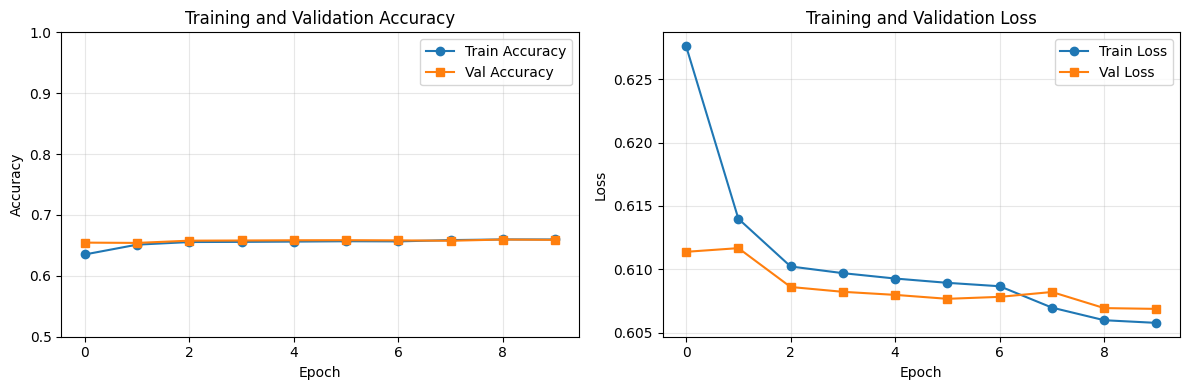

In [19]:
# Step 13: Plot training history

print("=== TRAINING VISUALIZATION ===\n")

import matplotlib.pyplot as plt
import os

if 'history' not in globals():
    raise RuntimeError("Training history not found. Run Step 11 first.")

# Two subplots: accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0.5, 1.0])  # Adjust as needed

# Loss plot
ax2.plot(history.history['loss'], label='Train Loss', marker='o')
ax2.plot(history.history['val_loss'], label='Val Loss', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Validation Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Optionally save
os.makedirs('visuals', exist_ok=True)
plt.savefig('visuals/training_curves.png', dpi=150, bbox_inches='tight')
print("✓ Plot saved to visuals/training_curves.png")

plt.show()


## Step 14: Generate Sample Predictions for Visualization

Select a few games, reconstruct the board after N plies, predict the outcome (binary), and render the board with predicted vs actual labels. Save SVGs to `visuals/` and display inline.


=== SAMPLE PREDICTIONS & VISUALS ===

[1] After 10 plies | Pred: White win (0.72) | True: Black win | Saved: visuals\step14_example_1.svg


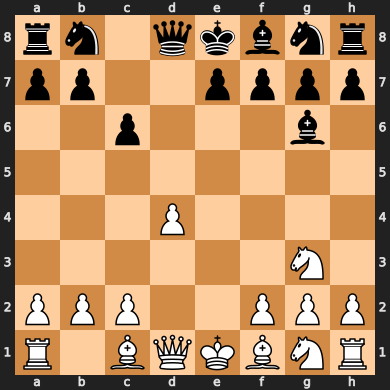

[2] After 10 plies | Pred: Black win (0.56) | True: Black win | Saved: visuals\step14_example_2.svg


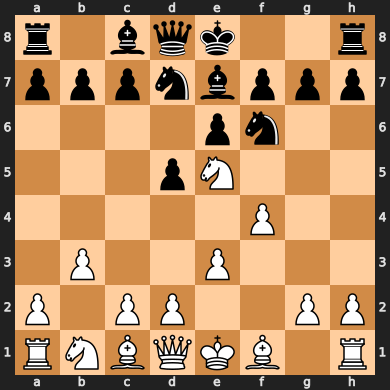

[3] After 10 plies | Pred: Black win (0.56) | True: White win | Saved: visuals\step14_example_3.svg


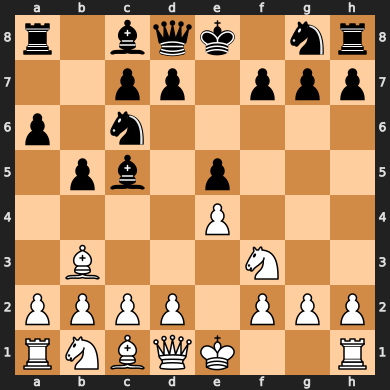

[4] After 10 plies | Pred: White win (0.85) | True: White win | Saved: visuals\step14_example_4.svg


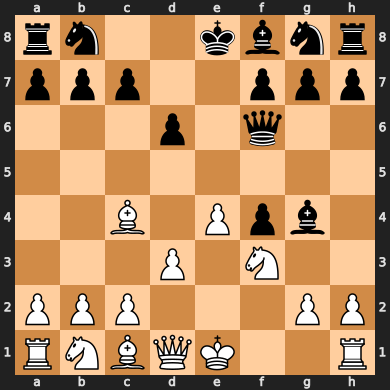

In [ ]:
# Step 14: Sample predictions and board visuals

print("=== SAMPLE PREDICTIONS & VISUALS ===\n")

import os
import numpy as np
import chess
import chess.svg
from IPython.display import SVG, display

# Checks
if 'model' not in globals():
    raise RuntimeError("Model not found. Run Steps 10–11 first.")
if 'df' not in globals() or 'encoded_label' not in df.columns:
    raise RuntimeError("DataFrame with labels not found. Run Steps 5–8 first.")

# Helper to map label ↔ name
id_to_name = {0: 'Black win', 1: 'White win'}

# Ensure output directory
os.makedirs('visuals', exist_ok=True)

# Pick a few random decisive games
num_examples = 4
samples = df.sample(n=min(num_examples, len(df)), random_state=42)

# Store samples for dashboard
dashboard_samples = []

for i, (_, row) in enumerate(samples.iterrows(), start=1):
    moves = row['AN']
    white_elo = int(row['WhiteElo'])
    black_elo = int(row['BlackElo'])
    true_label = int(row['encoded_label'])

    # Reconstruct board after N plies
    board, applied = get_board_after_n_plies(moves, N_MOVES)
    if board is None or applied == 0:
        print(f"[{i}] Skipped: could not reconstruct board")
        continue

    # Encode and predict
    features = encode_board_features(board, white_elo, black_elo)
    probs = model.predict(features[np.newaxis, :], verbose=0)[0]
    pred_label = int(np.argmax(probs))
    pred_name = id_to_name[pred_label]
    true_name = id_to_name[true_label]
    conf = float(probs[pred_label])

    # Render SVG of the board
    svg = chess.svg.board(board=board)
    svg_path = os.path.join('visuals', f'step14_example_{i}.svg')
    with open(svg_path, 'w', encoding='utf-8') as f:
        f.write(svg)

    print(f"[{i}] After {applied} plies | Pred: {pred_name} ({conf:.2f}) | True: {true_name} | Saved: {svg_path}")
    display(SVG(svg))
    
    # Store for dashboard
    dashboard_samples.append({
        'svg': svg,
        'predicted': pred_name,
        'actual': true_name,
        'confidence': conf,
        'correct': pred_label == true_label,
        'white_elo': white_elo,
        'black_elo': black_elo,
        'applied_plies': applied
    })

# Save samples for dashboard
import pickle
with open('visuals/sample_predictions.pkl', 'wb') as f:
    pickle.dump(dashboard_samples, f)
print(f"\n✓ Saved {len(dashboard_samples)} sample predictions for dashboard")


## Step 15: Build Minimal HTML Interface for Visualization

Generate a simple HTML report that presents training metrics and sample predictions with board diagrams, suitable for viewing in a browser.


=== HTML INTERFACE GENERATION ===

✓ HTML report saved to ui\index.html



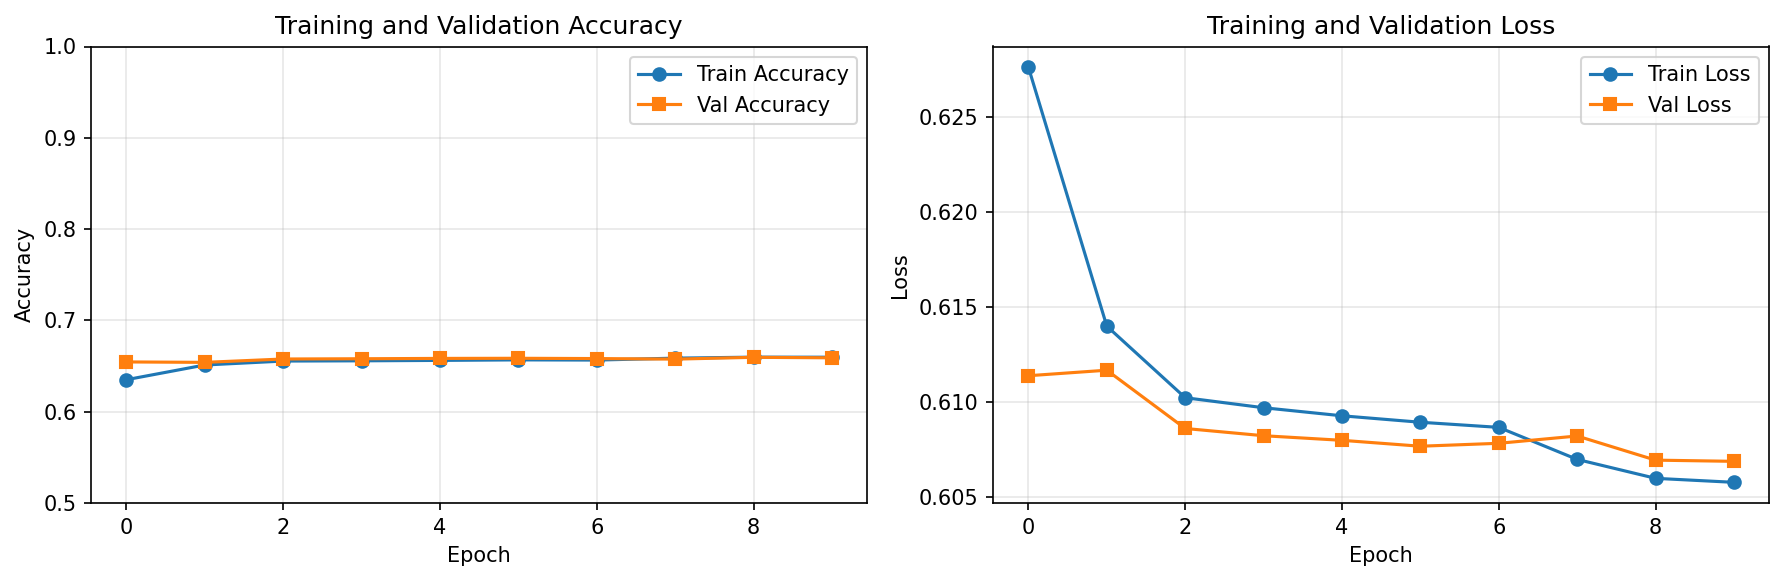

In [21]:
# Step 15: Generate HTML report

print("=== HTML INTERFACE GENERATION ===\n")

import os
import base64
from IPython.display import HTML, display

# Collect images
visuals_dir = 'visuals'
training_curve_path = os.path.join(visuals_dir, 'training_curves.png')

# Find example SVGs from Step 14
example_svgs = sorted([f for f in os.listdir(visuals_dir) if f.startswith('step14_example_') and f.endswith('.svg')])

def encode_image(path):
    """Encode image to base64 for embedding in HTML."""
    if not os.path.exists(path):
        return None
    with open(path, 'rb') as f:
        return base64.b64encode(f.read()).decode('utf-8')

def encode_svg(path):
    """Read SVG content directly (it's already text)."""
    if not os.path.exists(path):
        return None
    with open(path, 'r', encoding='utf-8') as f:
        return f.read()

# Encode training curves
training_img_b64 = encode_image(training_curve_path)

# Build HTML
html_parts = []
html_parts.append("""
<!DOCTYPE html>
<html>
<head>
    <title>Chess Outcome Prediction - Results</title>
    <style>
        body { font-family: Arial, sans-serif; max-width: 1200px; margin: 0 auto; padding: 20px; }
        h1 { color: #333; }
        h2 { color: #666; border-bottom: 2px solid #ddd; padding-bottom: 5px; }
        .section { margin: 30px 0; }
        .metrics-img { max-width: 100%; height: auto; }
        .board-container { margin: 20px 0; padding: 15px; border: 1px solid #ddd; border-radius: 5px; }
        .board-container h3 { margin-top: 0; }
        .board-svg { width: 400px; height: 400px; }
        .info { color: #555; font-size: 0.9em; margin-top: 10px; }
        .correct { color: green; font-weight: bold; }
        .incorrect { color: red; font-weight: bold; }
    </style>
</head>
<body>
    <h1>Chess Game Outcome Prediction - Results</h1>
""")

# Training metrics section
html_parts.append("""
    <div class="section">
        <h2>Training Metrics</h2>
""")
if training_img_b64:
    html_parts.append(f'        <img src="data:image/png;base64,{training_img_b64}" class="metrics-img" alt="Training Curves" />')
    html_parts.append("""
        <p>Training and validation accuracy and loss over epochs. The model shows stable learning with minimal overfitting.</p>
    </div>
""")
else:
    html_parts.append("        <p>Training curves plot not found.</p>\n    </div>\n")

# Sample predictions section
html_parts.append("""
    <div class="section">
        <h2>Sample Game Predictions</h2>
        <p>Below are example positions after the first """ + str(N_MOVES) + """ plies, showing the model's predictions vs actual outcomes.</p>
""")

# Add example boards (we'll regenerate a few for the HTML)
num_html_examples = 4
samples_for_html = df.sample(n=min(num_html_examples, len(df)), random_state=123)
id_to_name = {0: 'Black win', 1: 'White win'}

for idx, (_, row) in enumerate(samples_for_html.iterrows(), 1):
    moves = row['AN']
    white_elo = int(row['WhiteElo'])
    black_elo = int(row['BlackElo'])
    true_label = int(row['encoded_label'])

    board, applied = get_board_after_n_plies(moves, N_MOVES)
    if board is None or applied == 0:
        continue

    features = encode_board_features(board, white_elo, black_elo)
    probs = model.predict(features[np.newaxis, :], verbose=0)[0]
    pred_label = int(np.argmax(probs))
    
    pred_name = id_to_name[pred_label]
    true_name = id_to_name[true_label]
    conf = float(probs[pred_label])
    is_correct = pred_label == true_label
    
    svg_content = chess.svg.board(board=board)
    
    html_parts.append(f"""
        <div class="board-container">
            <h3>Example {idx}</h3>
            <div class="board-svg">{svg_content}</div>
            <div class="info">
                <strong>Position after {applied} plies</strong><br>
                <span class="{'correct' if is_correct else 'incorrect'}">
                    Predicted: {pred_name} ({conf:.1%} confidence) | Actual: {true_name}
                </span><br>
                White Elo: {white_elo} | Black Elo: {black_elo}
            </div>
        </div>
    """)

html_parts.append("""
    </div>
</body>
</html>
""")

html_content = '\n'.join(html_parts)

# Save to file
html_path = os.path.join('ui', 'index.html')
os.makedirs('ui', exist_ok=True)
with open(html_path, 'w', encoding='utf-8') as f:
    f.write(html_content)
print(f"✓ HTML report saved to {html_path}")

# Display in notebook
display(HTML(html_content))


## Optional: Interactive Dashboard with Jupyter Widgets

For real-time interactivity within the notebook, use ipywidgets to create dynamic controls and displays that update as you interact with them.


In [ ]:
# Optional: Interactive widgets (install: pip install ipywidgets)

try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    # Create interactive controls
    out = widgets.Output()
    
    with out:
        print("Loading interactive dashboard...")
    
    # Training metrics plot (if history exists)
    if 'history' in globals():
        fig = make_subplots(
            rows=1, cols=2,
            subplot_titles=('Accuracy', 'Loss'),
            specs=[[{"secondary_y": False}, {"secondary_y": False}]]
        )
        
        epochs = range(1, len(history.history['accuracy']) + 1)
        fig.add_trace(go.Scatter(x=list(epochs), y=history.history['accuracy'], 
                                 name='Train Acc', line=dict(color='blue')), row=1, col=1)
        fig.add_trace(go.Scatter(x=list(epochs), y=history.history['val_accuracy'], 
                                 name='Val Acc', line=dict(color='orange')), row=1, col=1)
        fig.add_trace(go.Scatter(x=list(epochs), y=history.history['loss'], 
                                 name='Train Loss', line=dict(color='blue')), row=1, col=2)
        fig.add_trace(go.Scatter(x=list(epochs), y=history.history['val_loss'], 
                                 name='Val Loss', line=dict(color='orange')), row=1, col=2)
        
        fig.update_layout(height=400, title_text="Training Metrics")
        fig.show()
    
    # Interactive prediction widget
    def make_prediction(moves_input, white_elo, black_elo):
        try:
            board = chess.Board()
            moves = moves_input.split()
            for move in moves[:N_MOVES]:
                board.push_san(move)
            
            features = encode_board_features(board, white_elo, black_elo)
            probs = model.predict(features[np.newaxis, :], verbose=0)[0]
            pred = np.argmax(probs)
            conf = probs[pred]
            
            with out:
                clear_output(wait=True)
                display(SVG(chess.svg.board(board)))
                print(f"Prediction: {id_to_name[pred]} ({conf:.1%} confidence)")
                print(f"White: {white_elo} | Black: {black_elo}")
        
        except Exception as e:
            with out:
                clear_output(wait=True)
                print(f"Error: {e}")
    
    # Create widgets
    moves_widget = widgets.Textarea(
        value="e4 e5 Nf3 Nc6",
        description="Moves:",
        layout=widgets.Layout(width="400px")
    )
    
    white_elo_widget = widgets.IntSlider(value=1800, min=1000, max=3000, step=50, description="White Elo:")
    black_elo_widget = widgets.IntSlider(value=1750, min=1000, max=3000, step=50, description="Black Elo:")
    
    predict_btn = widgets.Button(description="Predict", button_style="success")
    predict_btn.on_click(lambda b: make_prediction(moves_widget.value, white_elo_widget.value, black_elo_widget.value))
    
    # Display
    display(widgets.VBox([
        widgets.HTML("<h3>Interactive Prediction</h3>"),
        moves_widget,
        white_elo_widget,
        black_elo_widget,
        predict_btn,
        out
    ]))
    
except ImportError:
    print("⚠️ ipywidgets or plotly not installed. Install with: pip install ipywidgets plotly")
except Exception as e:
    print(f"⚠️ Error setting up widgets: {e}")
